# Approximate inference of parsimonious Bayesian context trees

This notebook provides examples to supplement the article *Approximate inference of parsimonious Bayesian context trees*, available on arXiv (https://arxiv.org/abs/2407.19236).

Code is provided to generate parsimonious Bayesian context tree (PBCT) structures, simulate sequences from trees, and fit PBCT structures to sequences using the agglomerative clustering algorithm described in the article. Comparisons are made with fixed and variable-order Markov models.

In [1]:
import pbct

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pprint import pprint

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

**Define simulation parameters**

In [4]:
# Set maximum tree depth, alpha value, and number of elements
V = 10
D = 2

alpha_sim = 1.0 # Controls cluster granularity
decay_alpha_sim = False # Option to decay the CRP parameter with depth; constrains tree size
gamma_sim = 1.0 # Controls rate of decay of alpha with tree depth

eta_sim = 1.0 # Simulated Dirichlet word distribution hyperparameter
lam_sim = 0.0 # Controls the tradeoff between Uniform and Dirichlet distributions over words (lam=0 gives Dirichlet, lam=1 gives Uniform)

N = 10000 # Length of sequence(s)
S = 1 # Number of sequences

# Minimum threshold for a leaf to contribute to the simulated sample
leaf_threshold = .005

**Simulate a PBCT and sequence**

In [5]:
sim_out = pbct.simulate_pbct_model(V=V, N=N, S=S
                                   ,max_depth=D, min_depth=D
                                  ,alpha_sim=alpha_sim
                                  ,decay_rate=decay_alpha_sim, gamma_sim=gamma_sim
                                  ,eta_sim=eta_sim,lam_sim=lam_sim
                                  ,leaf_threshold=leaf_threshold
                    )

crp_tree=sim_out['tree']
crp_counts=sim_out['leaf_counts']
x=sim_out['x']

print(crp_tree)

CRPTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)


**Visualise simulated tree**

In [6]:
crp_tree.visualise_tree(show_indices=True, counts=crp_counts)

|(): None
|-(0,): [0, 2, 3, 4, 5, 6, 7, 8, 9]
|--(0, 0): [0, 3, 4, 5, 6] -- 4096.0 (40.97%)
|--(0, 1): [1, 2, 8, 9] -- 3383.0 (33.84%)
|--(0, 2): [7] -- 1596.0 (15.96%)
|-(1,): [1]
|--(1, 0): [0, 9] -- 131.0 (1.31%)
|--(1, 1): [1, 3, 4, 7, 8] -- 489.0 (4.89%)
|--(1, 2): [2, 6] -- 226.0 (2.26%)
|--(1, 3): [5] -- 77.0 (0.77%)


**Get train-test split of simulated sequence(s)**

In [7]:
train_size = 0.9
# test_size = 0.1
x_train, x_test, x_stats = pbct._train_test_split(x, V
                                    ,train_size=train_size
#                                     ,test_size=test_size
                                    ,return_statistics=True
                                   )
N_test = x_stats['N_test']
N_train = x_stats['N_train']
print(x_stats)

{'S': 1, 'N': 10000, 'S_train': 1, 'S_test': 1, 'N_total': 10000, 'N_train': 9000, 'N_test': 1000}


**Visualise simulated tree structure and word distributions**

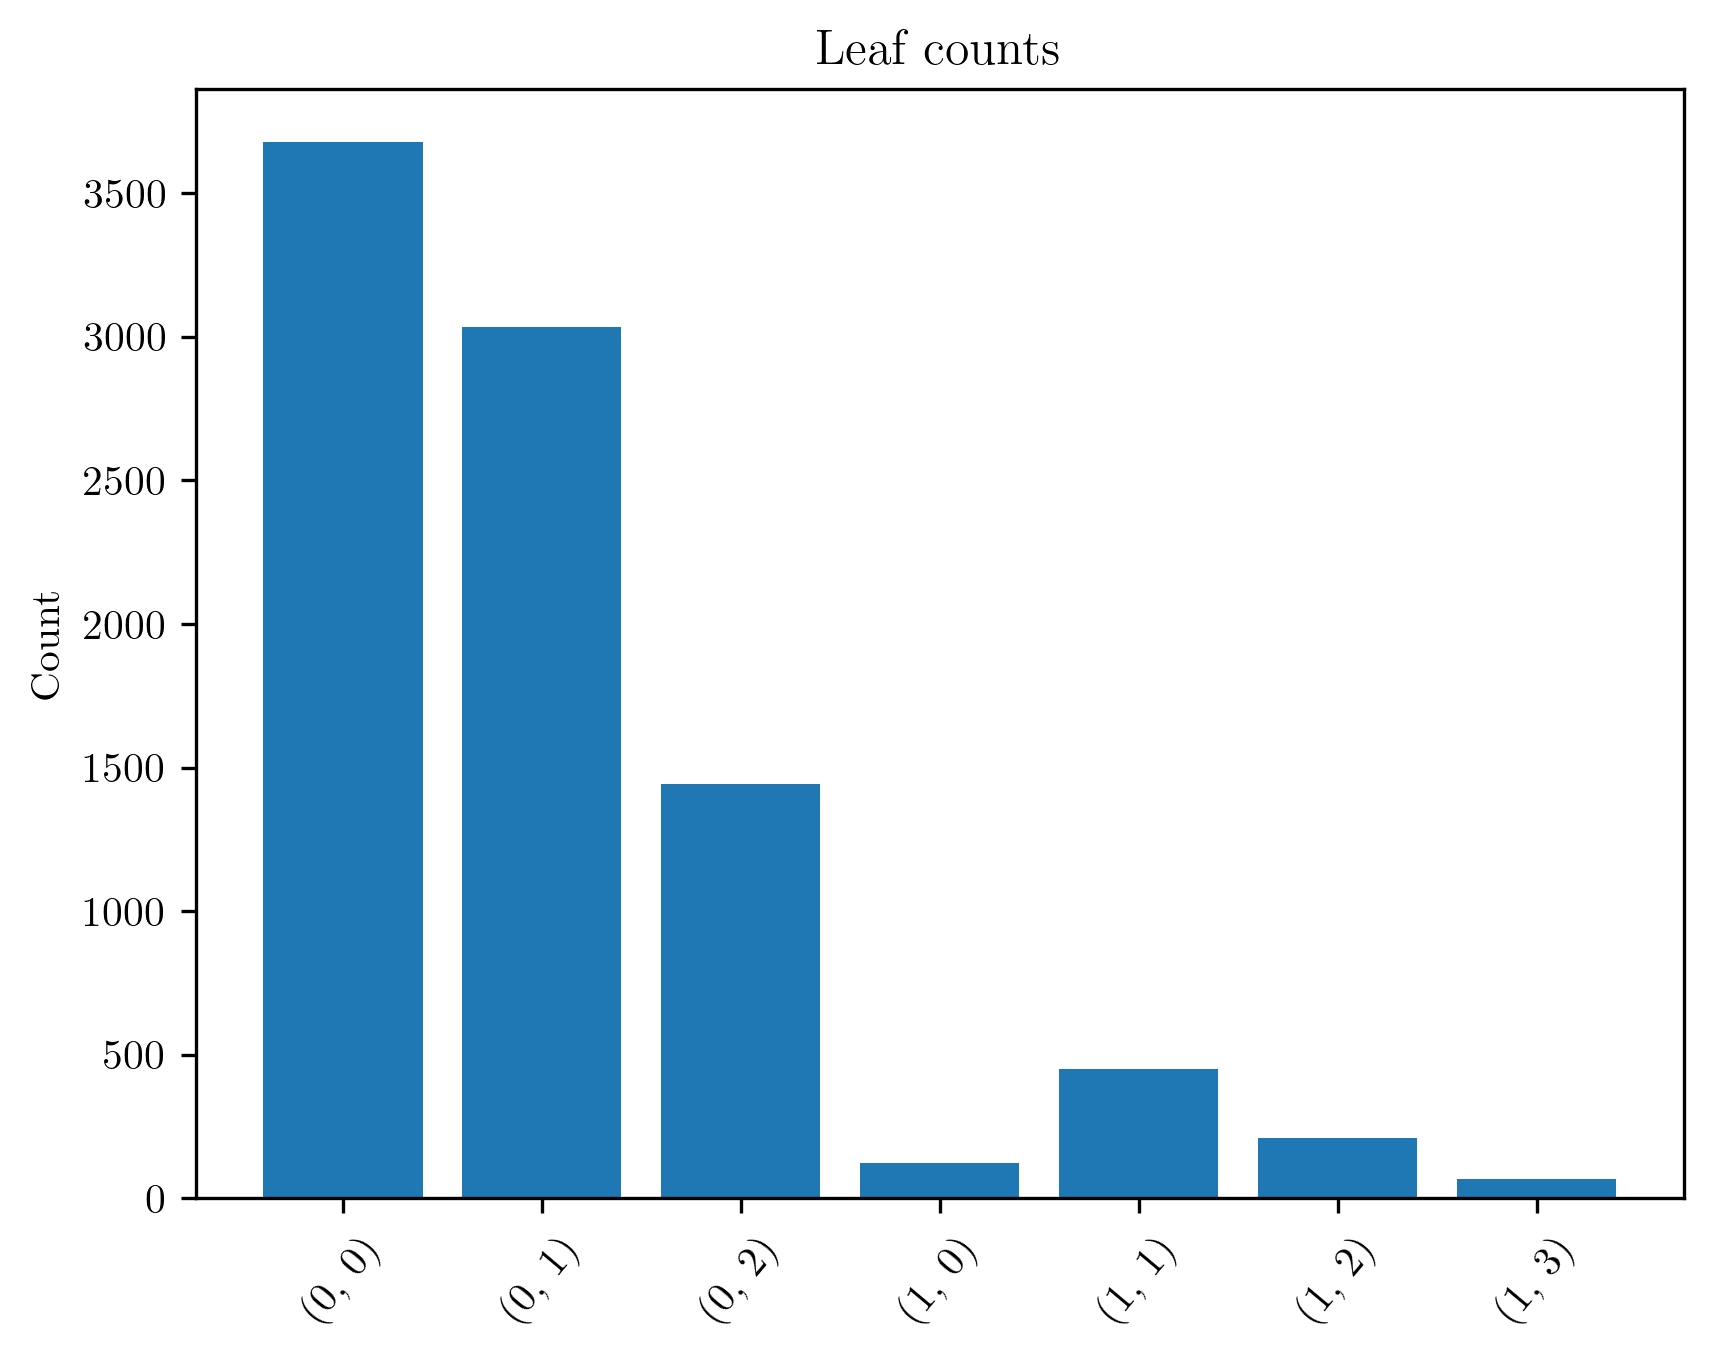

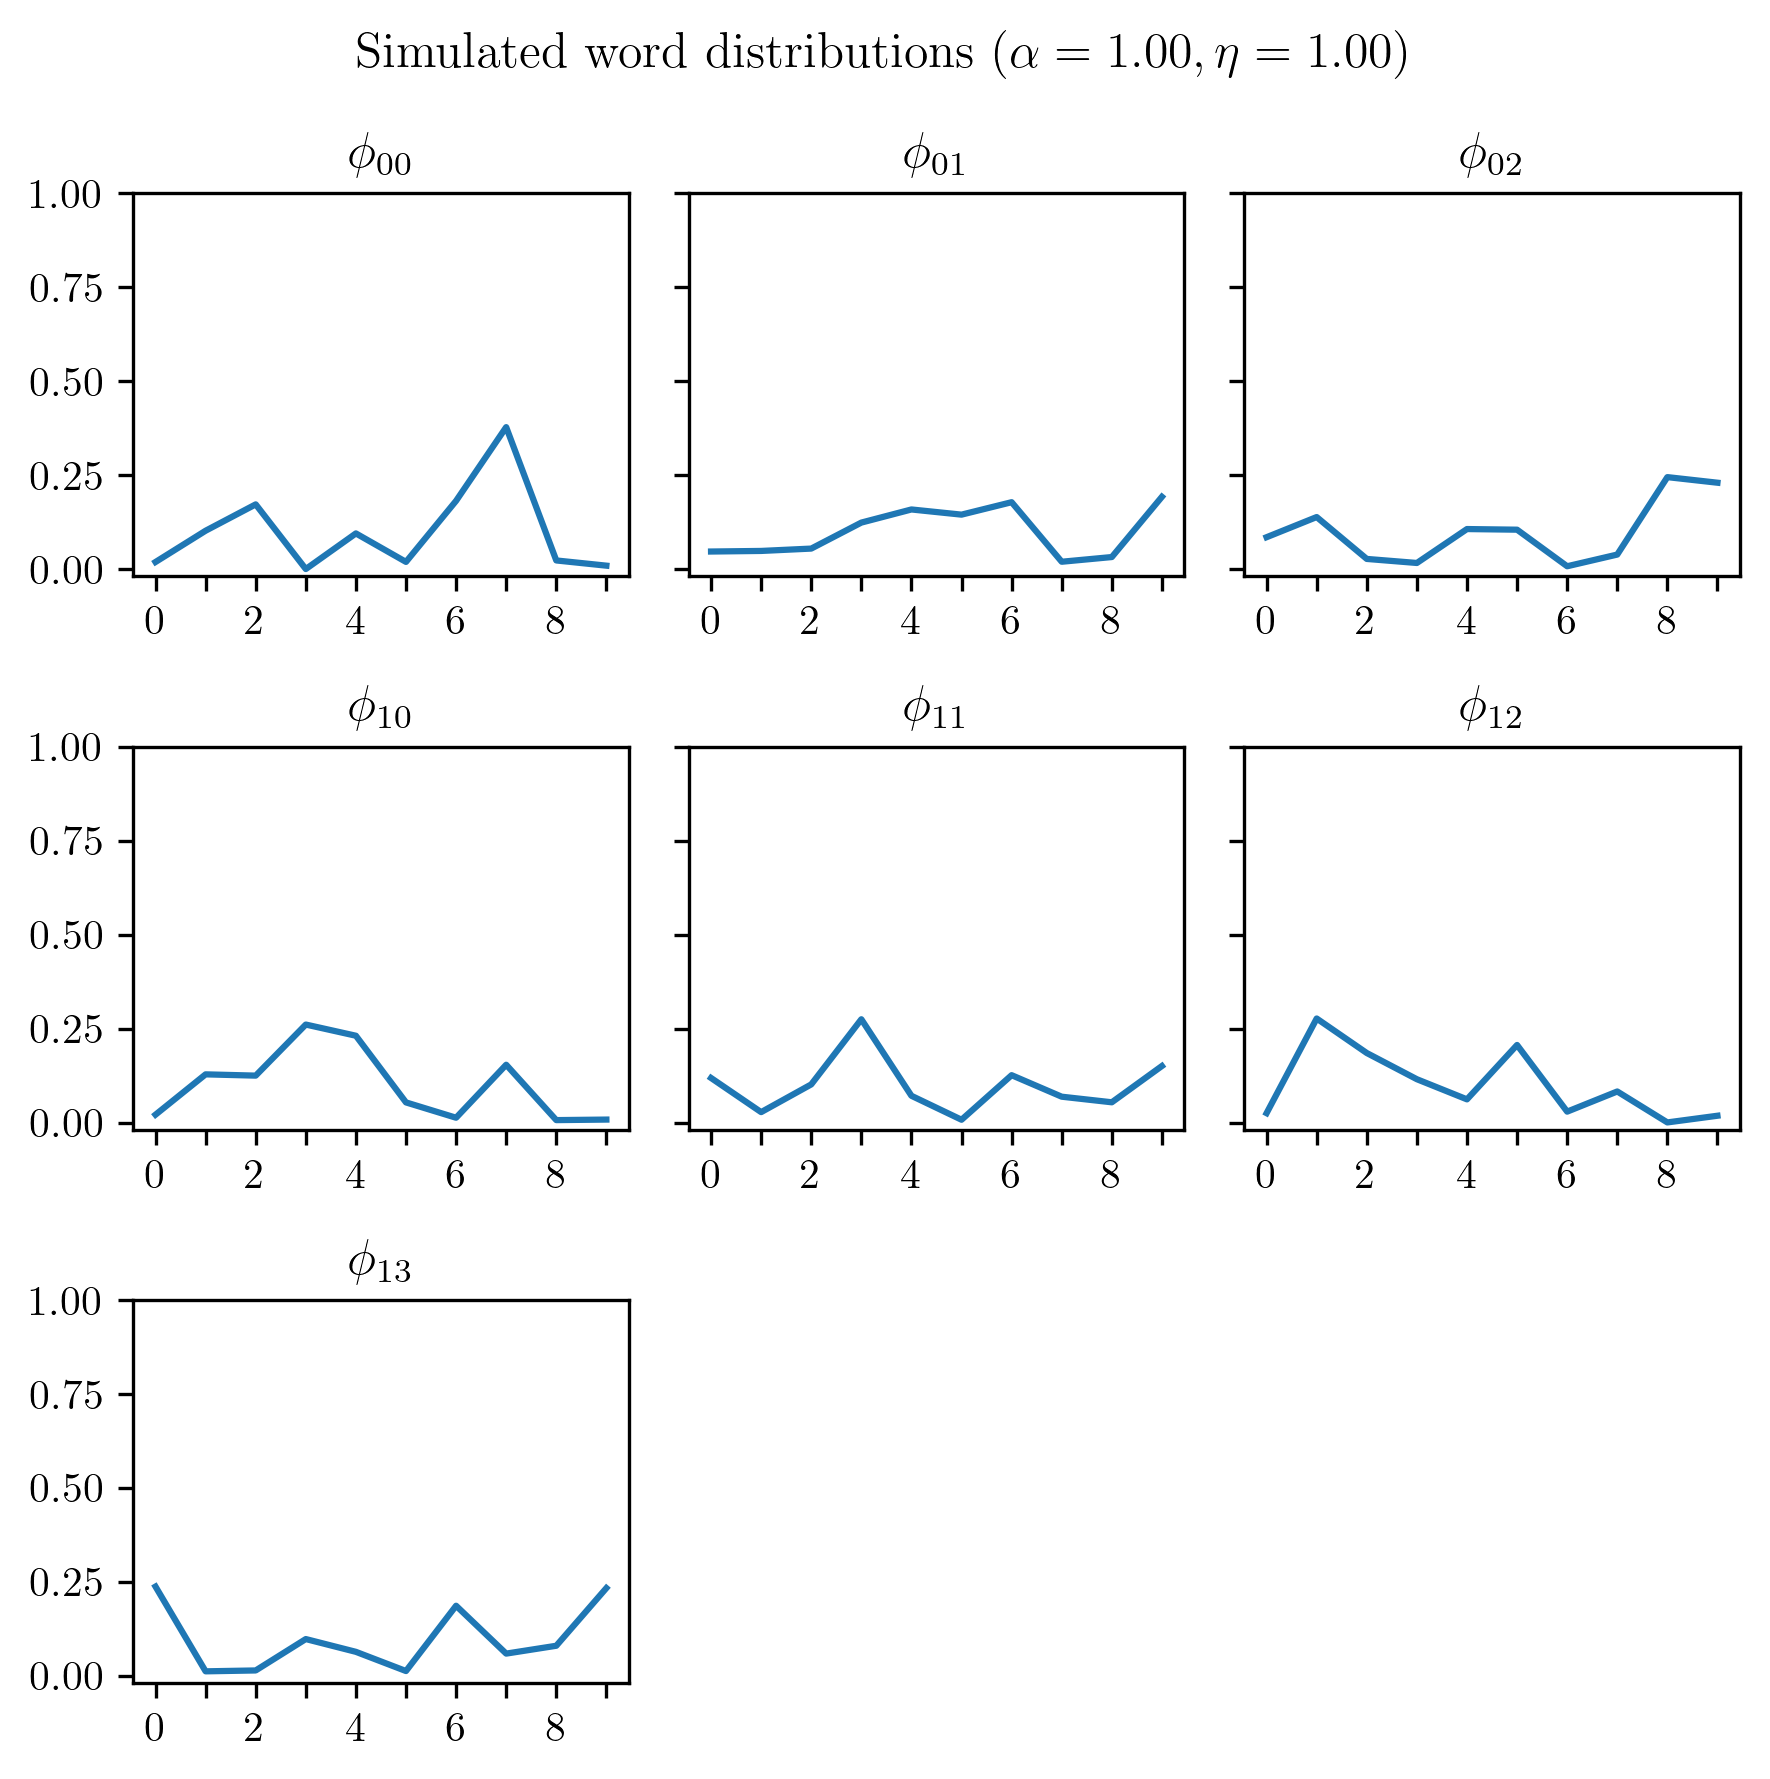

In [8]:
%matplotlib inline
pbct.plot_leaf_counts(crp_tree=crp_tree, x=x_train)
crp_tree.plot_simulated_pmfs(all_pmfs=False)


**Fit model on simulated sequence; define training parameters**

In [9]:
eta_train = eta_sim # Dirichlet leaf pmfs parameter
alpha_train = alpha_sim # (Initial) CRP rate parameter
decay_alpha = decay_alpha_sim
gamma_train = gamma_sim # Rate of decay of alpha (CRP rate)

crp_prior = True # Multiply likelihood by CRP prior in agglomerative clustering objective (posterior)


**Learn tree structure by recursive agglomerative clustering (RAC) method**

In [10]:
fit_tree = pbct.PBCT(V=V
                  ,max_depth=D
                  ,alpha=alpha_train
                  ,eta=eta_train
                  ,crp_prior=crp_prior
                  ,agg_clust=True
                  ,MCMC=False
                 )

# Estimate Markov tree using agglomerative clustering
fit_tree.fit(x_train) 
print(fit_tree)

PCTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)


**Compare simulated and fitted models**

In [11]:
print(crp_tree)
crp_tree.visualise_tree(show_indices=True)
print(fit_tree)
fit_tree.visualise_tree(show_indices=True)

CRPTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)
|(): None
|-(0,): [0, 2, 3, 4, 5, 6, 7, 8, 9]
|--(0, 0): [0, 3, 4, 5, 6]
|--(0, 1): [1, 2, 8, 9]
|--(0, 2): [7]
|-(1,): [1]
|--(1, 0): [0, 9]
|--(1, 1): [1, 3, 4, 7, 8]
|--(1, 2): [2, 6]
|--(1, 3): [5]
PCTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)
|(): None
|-(0,): [0, 2, 4, 7, 8, 5, 6, 9, 3]
|--(0, 0): [0, 6, 3, 4, 5]
|--(0, 1): [1, 8, 2, 9]
|--(0, 2): [7]
|-(1,): [1]
|--(1, 0): [0, 9]
|--(1, 1): [1, 8, 7, 3, 4]
|--(1, 2): [2, 6]
|--(1, 3): [5]


**Model evaluation via log-loss**

In [12]:
# Model comparison via log loss
fit_loss, fit_leaf_loss = fit_tree.log_loss(x_train=x_train, x_test=x_test, eta=eta_train, out_prop=True)
sim_loss, sim_leaf_loss = crp_tree.log_loss(x_train=x_train, x_test=x_test, eta=eta_sim, out_prop=True)
true_loss = crp_tree.empirical_log_loss(x_test)

# Get posterior mean leaf pmfs
fit_pmfs = fit_tree.estimate_leaf_pmfs(x_train, eta_train)
# Get empirical loss using estimated pmfs
empirical_loss = fit_tree.empirical_log_loss(x_test, leaf_pmfs=fit_pmfs)

print('Fitted tree log-loss:', fit_loss)
print('Simulated tree log-loss:', sim_loss)
print('Fitted - simulated log-loss:', fit_loss - sim_loss)
print('True log-loss:', true_loss)
print('Fitted - true log-loss:', fit_loss - true_loss)

Fitted tree log-loss: 1.8973836941555822
Simulated tree log-loss: 1.8973836941555822
Fitted - simulated log-loss: 0.0
True log-loss: 1.8938690777434262
Fitted - true log-loss: 0.003514616412156002


**Compare trees via ARI**

In [13]:
out_ari = pbct.compare_trees(fit_tree
                        ,crp_tree
                        ,V=V
                        ,x=x_train
                        ,return_partitions=False
                        ,compare_max_depth=D
                       ,compare_full_trees=True)

ari_values = out_ari['ari_values']
ari_values_average = out_ari['ari_values_average']

In [14]:
print('Average ARI values {depth:ARI_average}')
pprint(ari_values_average)

Average ARI values {depth:ARI_average}
{1: 1.0, 2: 1.0}


**Plot Jensen-Shannon distances (divergences) between simulated and fitted leaf pmfs**

In [15]:
from scipy.spatial.distance import jensenshannon

sim_pmfs = crp_tree.leaf_pmfs
fit_pmfs = fit_tree.estimate_leaf_pmfs(x_train, eta_train)

sim_indices = {i:idx for i, idx in enumerate(crp_tree.leaf_indices)}
fit_indices = {i:idx for i, idx in enumerate(fit_tree.leaf_indices)}
sim_indices_str = [str(idx) for idx in sim_indices.values()]
fit_indices_str = [str(idx) for idx in fit_indices.values()]

In [16]:
L_sim = len(sim_indices)
L_fit = len(fit_indices)

JS = np.zeros((L_sim,L_fit),dtype=float)

for i, sim_idx in sim_indices.items():
    for j, fit_idx in fit_indices.items():
        JS[i,j] += jensenshannon(sim_pmfs[sim_idx], fit_pmfs[fit_idx])

In [17]:
sns.set(font="Times New Roman", rc={'figure.figsize':(8,6), 'figure.dpi':120})

In [18]:
# Match entries in J by the highest similarity
from scipy.optimize import linear_sum_assignment
sim_ind, fit_ind0 = linear_sum_assignment(JS)
not_matched = np.setdiff1d(np.arange(L_fit), fit_ind0)
fit_ind = np.concatenate((fit_ind0, not_matched))
JS_align = JS[sim_ind][:,fit_ind]

# Get aligned leaf indices as strings
sim_ind_str = [str(sim_indices[i]) for i in sim_ind]
fit_ind_str = [str(fit_indices[i]) for i in fit_ind]

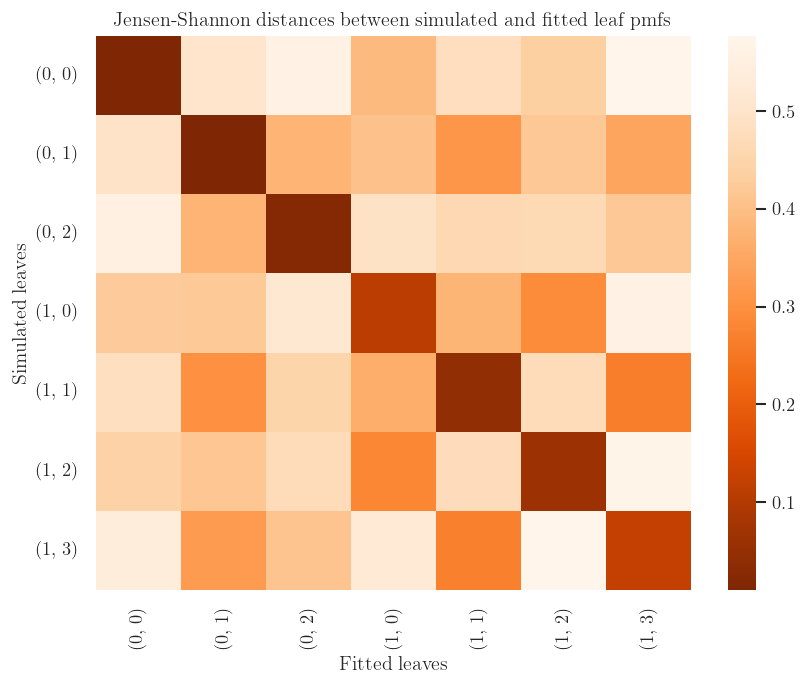

In [19]:
# Create a dataframe from distance matrix
df_align = pd.DataFrame(JS_align, index=sim_ind_str, columns=fit_ind_str)

# Aligned heatmap
ax = sns.heatmap(df_align, cmap=sns.color_palette("Oranges_r", as_cmap=True))
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)
ax.set_xlabel('Fitted leaves')
ax.set_ylabel('Simulated leaves')
plt.title('Jensen-Shannon distances between simulated and fitted leaf pmfs')
plt.show()

**Comparison with other models: fixed Bayesian Markov (FBM)**

In [34]:
orders = range(0,D+1)
fbm_ll_best = np.inf
for d in orders:
    fbm_tree = pbct.FBM(V=V, max_depth=d)
    fbm_tree.generate_tree()
    print(fbm_tree)
    fbm_ll, fbm_leaf_ll = fbm_tree.log_loss(x_train=x_train, x_test=x_test, eta=eta_train, out_prop=True)
    
    if fbm_ll < fbm_ll_best:
        fbm_ll_best = fbm_ll
        fbm_tree_best = fbm_tree
        
    print(f'FBM-{d} log-loss:', fbm_ll)
    print('-'*40)

FBMTree(V=10, order=0, n_leaves=1)
FBM-0 log-loss: 2.2358432230893013
----------------------------------------
FBMTree(V=10, order=1, n_leaves=10)
FBM-1 log-loss: 2.222767965627853
----------------------------------------
FBMTree(V=10, order=2, n_leaves=100)
FBM-2 log-loss: 1.9314084220739443
----------------------------------------


**Variable-order Bayesian Markov (VBM)**

In [21]:
# VBM specific parameters
theta_train = 1/V # Must be 0<p<1
decay_theta=False
bernoulli_prior=True

In [22]:
# Fit VBM
vbm_tree = pbct.VBM(V=V, max_depth=D,
              eta=eta_train, theta=theta_train,
              decay_theta=decay_theta, gamma=gamma_train,
              bernoulli_prior=bernoulli_prior)

vbm_tree.fit(x_train)

print(vbm_tree)

VBMTree(V=10, theta=0.1, max_depth=2, n_leaves=100)


In [26]:
vbm_loss = vbm_tree.log_loss(x_train=x_train, x_test=x_test, eta=eta_train)

1.9314084220739443


In [37]:
print('Simulated tree:', crp_tree)
print('Simulated tree log-loss:', round(sim_loss,5))
print('-'*50)
print(fit_tree)
print('PBCT log-loss:', round(fit_loss,5))
print('PBCT-sim log-loss:', round(fit_loss-sim_loss,5))
print('-'*50)
print(vbm_tree)
print('VBM log-loss:', round(vbm_loss,5))
print('VBM-sim log-loss:', round(vbm_loss-sim_loss,5))
print('-'*50)
print('Best FBM:', fbm_tree_best)
print('FBM log-loss:', round(fbm_ll_best,5))
print('FBM-sim log-loss:', round(fbm_ll_best-sim_loss,5))


Simulated tree: CRPTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)
Simulated tree log-loss: 1.89738
--------------------------------------------------
PCTree(V=10, alpha=1.0, max_depth=2, n_leaves=7)
PBCT log-loss: 1.89738
PBCT-sim log-loss: 0.0
--------------------------------------------------
VBMTree(V=10, theta=0.1, max_depth=2, n_leaves=100)
VBM log-loss: 1.93141
VBM-sim log-loss: 0.03402
--------------------------------------------------
Best FBM: FBMTree(V=10, order=2, n_leaves=100)
FBM log-loss: 1.93141
FBM-sim log-loss: 0.03402
